In [1]:
from tqdm import tqdm
import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
data_path = '/home/rfit/Telescope_Array/phd_work/data/normed/pr_q4_14yr_e1_0110_excl_sat_F_excl_geo_F.h5'

In [2]:
with h5.File(data_path,'r') as f:
    print('keys', list(f.keys()))
    train = f['train']
    norm_param = f['norm_param']['dt_params']
    norm_param_std = norm_param['std'][()]
    norm_param_mean = norm_param['mean'][()]
    print(list(norm_param.keys()))
    print(list(train.keys()))
    dt_params = train['dt_params'][()]
    ev_starts = train['ev_starts'][()]
    val = f['test']
    val_dt_mask = val['dt_mask'][()]
    val_dt_params = val['dt_params'][()]
    val_ev_starts = val['ev_starts'][()]

keys ['norm_param', 'test', 'train', 'val']
['mean', 'std']
['dt_bundle', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']


In [3]:
val_ev_starts.shape, ev_starts.shape

((499796,), (4498160,))

In [4]:
# example
dt_params[1]*norm_param_std + norm_param_mean

array([ 1.11465  ,  2.19913  ,  0.0533297,  1.8858643, -4.607    ,
        4.362    ], dtype=float32)

dt_params (num_dets,6):
0. detector x relative to shower core, 1200 m units
1. detector y relative to shower core, 1200 m units
2. detector z, 1200 m units
3. detector signal MIP
4. time of the plane front arrival, mks
5. time of the waveform relative to the plane front, mks

In [5]:
ev_starts

array([        0,        43,        73, ..., 111191147, 111191169,
       111191190])

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 4.42080e+04, 1.12861e+05, 1.62915e+05,
        1.85646e+05, 1.89262e+05, 1.84136e+05, 1.75026e+05, 1.68160e+05,
        1.61514e+05, 1.54314e+05, 1.47710e+05, 1.40716e+05, 1.33239e+05,
        1.26908e+05, 1.21622e+05, 1.15912e+05, 1.10966e+05, 1.07531e+05,
        1.04043e+05, 1.01588e+05, 9.84940e+04, 9.69020e+04, 9.45740e+04,
        9.10940e+04, 8.86930e+04, 8.55780e+04, 8.20510e+04, 7.91710e+04,
        7.55220e+04, 7.20130e+04, 6.86600e+04, 6.52650e+04, 6.20630e+04,
        5.90220e+04, 5.55140e+04, 5.28300e+04, 5.00310e+04, 4.75170e+04,
        4.47500e+04, 4.16830e+04, 3.93200e+04, 3.62470e+04, 3.37840e+04,
        3.08510e+04, 2.81300e+04, 2.59300e+04, 2.26850e+04, 2.05690e+04,
        1.78300e+04, 1.56430e+04, 1.33530e+04, 1.13990e+04, 9.47800e+03,
        7.69700e+03, 6.24100e+03, 4.93600e+03, 3.81000e+03, 2.84600e+03,
        2.15900e+03, 1.65800e+03, 1.18600e+03, 8.46

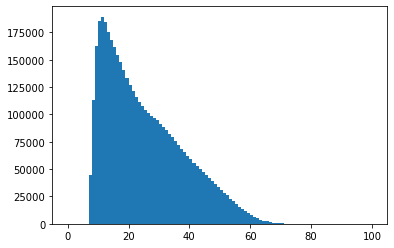

In [6]:
plt.hist(np.diff(ev_starts), bins = 100, range = (0,100))

In [7]:
dt_params.shape

(111191190, 6)

In [9]:
def sorted_by(data, key = 'plane'):
    if key == 'plane':
        data = data.sort(5)
    return data
# sorted_by(dt_params[:43], key = 'plane')

In [10]:
np.argsort(dt_params[:43,4])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  9, 11, 12, 13, 14, 15, 16,
       17, 18, 22, 21, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 32, 31, 33,
       34, 35, 36, 37, 38, 40, 41, 39, 42])

In [11]:
ev_starts.shape, dt_params.shape

((4498160,), (111191190, 6))

In [12]:
def data_split(data, ev_start):
    st = ev_start[0]
    for fn in ev_start[1:]:
        data_ev = data[st:fn]
        st = fn
    
data_split(dt_params, ev_starts)

In [13]:
# VAE

In [13]:
import torch
torch.__version__

'1.10.1+cu111'

# from https://github.com/Sebastian-Ballesteros/music_tranformer_vae/blob/main/GPTmuseVAE.py

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_size, z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc21 = nn.Linear(32, z_dim)
        self.fc22 = nn.Linear(32, z_dim)
        self.fc3 = nn.Linear(z_dim, 64)
        self.fc4 = nn.Linear(64, input_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) 
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        B, T, C = x.size()
        mu, logvar = self.encode(x.view(B * T, C))
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(B, T, -1)), mu, logvar

    def forward_z(self, x, z_vector, magnitude=1):
        B, T, C = x.size()
        mu, logvar = self.encode(x.view(B * T, C))

        # Manipulate the latent space
        z = self.reparameterize(mu, logvar)
        z += (magnitude * z_vector)

        return self.decode(z.view(B, T, -1)), mu, logvar

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_heads, head_size, n_embd, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size,n_embd, block_size, dropout) for _ in range(n_heads)])
        self.proj = nn.Linear(head_size * n_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout, block_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, dropout, block_size)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTmuseVAE(nn.Module):

    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout, z_dim):
        super().__init__()
        self.block_size = block_size
        print(vocab_size, n_embd, n_head, n_layer, block_size, dropout, z_dim)
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, dropout, block_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.vae = VAE(n_embd, z_dim)
        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None ,latent_vector = None, magnitude= None, device = 'cpu'):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)

        ## Incorporate vae here VAE (x,z_vector,magnitude)
        if latent_vector is not None:
            x_vae, mu, logvar = self.vae.forward_z(x, latent_vector, magnitude)

        else:
            x_vae, mu, logvar = self.vae.forward(x)

        logits = self.lm_head(x_vae) # (B,T,vocab_size)

        if targets is None:
            prediction_loss = None
            vae_loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            prediction_loss = F.cross_entropy(logits, targets)
            reconstruction_loss =  F.mse_loss(x_vae, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            vae_loss = reconstruction_loss + kl_loss

        return logits, prediction_loss, vae_loss

    def generate(self, idx, max_new_tokens, latent_vector = None, magnitude = None ):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss , loss_vae = self(idx_cond, targets = None, latent_vector = latent_vector, magnitude = magnitude)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, magnitude
    
    def sample_latent (self, idx, device='cpu'):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        mu, logvar = self.vae.encode(x)
        x = self.vae.reparameterize(mu, logvar)
        return x

    
def main():
    # Example usage:
    vocab_size = 10000
    n_embd = 256
    n_head = 8
    n_layer = 6
    block_size = 128
    dropout = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = GPTmuseVAE(vocab_size, n_embd, n_head, n_layer, block_size, dropout, 30)

    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

if __name__ == "__main__":
    main()

10000 256 8 6 128 0.1 30
9.92606 M parameters


In [25]:
vocab_size = 10000
n_embd = 256
n_head = 8
n_layer = 6
block_size = 128
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPTmuseVAE(vocab_size, n_embd, n_head, n_layer, block_size, dropout, 30)

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')


10000 256 8 6 128 0.1 30
9.92606 M parameters


In [26]:
import torchvision

model_graph = draw_graph(model(), input_size=(1,128), expand_nested=True)
model_graph.visual_graph

NameError: name 'draw_graph' is not defined

In [28]:
!pip install torchview

ERROR: Could not find a version that satisfies the requirement torchview (from versions: none)
ERROR: No matching distribution found for torchview


# VAE LSTM(GPT)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class VariableLengthDataset(Dataset):
    def __init__(self, data, ev_starts):
        """
        Args:
            data: список тензоров, где каждый тензор имеет форму (seq_len, 5)
        """
        self.data = data
        self.ev_starts = ev_starts

    def __len__(self):
        return len(self.ev_starts)-1

    def __getitem__(self, idx):
        st = self.ev_starts[idx]
        fn = self.ev_starts[idx + 1]
        return torch.tensor(self.data[st:fn])

def collate_fn(batch):
    """
    Кастомная функция для DataLoader, которая заполняет последовательности до максимальной длины в батче.
    """
    # Извлекаем каждую последовательность в батче
    sequences = [item for item in batch]
    # Заполняем последовательности до одинаковой длины
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=-1.0)  # (batch_size, max_seq_len, 5)
    return padded_sequences

# Пример данных (можете заменить его своими реальными данными)
# Создадим случайные данные с длиной от 5 до 120 для каждой последовательности
data = [torch.randn(torch.randint(5, 121, (1,)).item(), 5) for _ in range(100)]  # 100 последовательностей разной длины
# Инициализируем датасет и DataLoader
dataset = VariableLengthDataset(dt_params, ev_starts)
val_dataset = VariableLengthDataset(val_dt_params, val_ev_starts)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Проверка
# for batch in train_loader:
#     print("Batch size:", batch.size(0))  # размер батча
#     print("Batch sequence length:", batch.size(1))  # длина самой длинной последовательности в батче
#     print("Data shape:", batch.shape)  # (batch_size, max_seq_len_in_batch, 5)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # h_n shape: (1, batch_size, hidden_dim)
        h_n = h_n.squeeze(0)  # убираем первую размерность
        mu = self.fc_mu(h_n)  # среднее латентного пространства
        log_var = self.fc_logvar(h_n)  # логарифм дисперсии латентного пространства
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_len):
        h = torch.relu(self.fc(z)).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        h = h.repeat(1, seq_len, 1)  # Повторяем скрытое состояние для каждого шага времени
        lstm_out, _ = self.lstm(h)  # Проходим через LSTM
        return self.output_layer(lstm_out)

class VAE(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        seq_len = x.size(1)
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z, seq_len)
        return recon_x, mu, log_var

# Функция потерь
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence / x.size(0)

# Настройка обучения
input_dim = 6
hidden_dim = 64
latent_dim = 16
batch_size = 500
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Цикл обучения (предполагается, что train_loader предоставляет пакеты последовательностей переменной длины)
epochs = 20
PATH = '../Models_VAE/model1'
os.makedirs(PATH, exist_ok = True)
for epoch in range(epochs):
    pbar = tqdm(train_loader, desc =f"Epoch {epoch + 1}/{epochs}, Loss: 0.0")
    for x in pbar:  # x должен быть пакетом последовательностей с заполнением
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(x)
        loss = vae_loss(recon_x, x, mu, log_var)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    loss_mean = []
    for x in tqdm(val_loader, desc ='Validation'):  # x должен быть пакетом последовательностей с заполнением
        x = x.to(device)
        recon_x, mu, log_var = model(x)
        loss = vae_loss(recon_x, x, mu, log_var)
        loss_mean.append(loss)
    torch.save(model.state_dict(), os.path.join(PATH, f'epoch_{epoch}'))
    print(f'Epoch {epoch + 1}, Loss: {np.array(loss_mean).mean()}')



Epoch 1/20, Loss: 0.0:   0%|          | 0/8997 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 9.49 GiB already allocated; 3.44 MiB free; 10.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Links

https://habr.com/ru/articles/486358/ - Trnsformers